## Importing Libraries


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

## Read Dataset


In [3]:
df = pd.read_csv("pakwheels.csv")

## --------------------------------------Understand the data---------------------------------------------------------------

## 1) Data preprocessing

## 2) Data Exploration

## 3) Data cleaning


In [4]:
df.head(3)

,Unnamed: 0,ad_url,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,car_features,description
0,0,https://www.pakwheels.com/used-cars/honda-civi...,Honda Civic VTi Oriel Prosmatec 1.8 i-VTEC 2007,Islamabad Islamabad,2007.0,PKR 16.5 lacs,"100,000 km",Petrol,Automatic,Lahore,Grey,Imported Cars,1800 cc,Sedan,"Oct 09, 2022",ABS\nAM/FM Radio\nAir Bags\nAir Conditioning\n...,2007 model full option Chat piller geniune or ...
1,1,https://www.pakwheels.com/used-cars/suzuki-meh...,Suzuki Mehran VX Euro II 2012,"Eden Gardens, Faisalabad Punjab",2012.0,PKR 7 lacs,"100,000 km",Petrol,Manual,Faisalabad,Grey,Imported Cars,800 cc,Hatchback,"Oct 09, 2022",AM/FM Radio\nCD Player\nImmobilizer Key,"Very smooth drive,70% in orignal paint rest of..."
2,2,https://www.pakwheels.com/used-cars/honda-civi...,Honda Civic EX 1995,"Bostan Road, Rawalpindi Punjab",1995.0,PKR 7.6 lacs,999 km,Petrol,Manual,Lahore,Black,Imported Cars,1500 cc,Sedan,"Oct 09, 2022",AM/FM Radio\nAir Conditioning\nAlloy Rims\nCas...,1600cc Engine installed Alloy RimsAir Conditio...


# -----------------------------------------------------------------------------------------------------------------


In [5]:
df.columns

Index(['Unnamed: 0', 'ad_url', 'title', 'location', 'model_year', 'price',
       'mileage', 'engine_type', 'transmission', 'registered_in', 'color',
       'assembly', 'engine_capacity', 'body_type', 'ad_last_updated',
       'car_features', 'description'],
      dtype='object')

In [6]:
df.dtypes

Unnamed: 0           int64
ad_url              object
title               object
location            object
model_year         float64
price               object
mileage             object
engine_type         object
transmission        object
registered_in       object
color               object
assembly            object
engine_capacity     object
body_type           object
ad_last_updated     object
car_features        object
description         object
dtype: object

In [7]:
df["ad_last_updated"] = pd.to_datetime(df["ad_last_updated"])

In [8]:
df["ad_last_updated"].max()

Timestamp('2022-10-10 00:00:00')

### The dataset we have is of vehicles posted on pakwheels upto 10/october/2022


# ---------------------------------------------------------------------------------------------------------------


# Data Cleaning


## 1) Drop irrelevant columns


In [9]:
df.drop(["Unnamed: 0", "ad_url", "description", "car_features"], axis=1, inplace=True)

In [10]:
df.head(1)

,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated
0,Honda Civic VTi Oriel Prosmatec 1.8 i-VTEC 2007,Islamabad Islamabad,2007.0,PKR 16.5 lacs,"100,000 km",Petrol,Automatic,Lahore,Grey,Imported Cars,1800 cc,Sedan,2022-10-09


In [11]:
df.shape

(89956, 13)

In [12]:
print("We have data of", df.shape[0], "vehicles")

We have data of 89956 vehicles


## Create individual columns for vehicle name, variant from title columns


In [13]:
df["title"].str.split(" ")[0][0]

'Honda'

In [14]:
df["brand"] = df.title.apply(lambda x: (x.split(" ")[0]))

In [15]:
df.brand.nunique()

73

In [16]:
df["vehicle"] = df.title.apply(lambda x: (x.split(" ")[1]))

In [17]:
df.head(1)

,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,brand,vehicle
0,Honda Civic VTi Oriel Prosmatec 1.8 i-VTEC 2007,Islamabad Islamabad,2007.0,PKR 16.5 lacs,"100,000 km",Petrol,Automatic,Lahore,Grey,Imported Cars,1800 cc,Sedan,2022-10-09,Honda,Civic


In [18]:
print("NO OF UNIQUE VEHICLES ARE = ", df.vehicle.nunique())

NO OF UNIQUE VEHICLES ARE =  465


In [19]:
df["variant"] = df.title.apply(lambda x: (x.split(" ")[2:-1]))

In [20]:
df.variant = df.variant.str.join(" ")

In [21]:
df.head(1)

,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,brand,vehicle,variant
0,Honda Civic VTi Oriel Prosmatec 1.8 i-VTEC 2007,Islamabad Islamabad,2007.0,PKR 16.5 lacs,"100,000 km",Petrol,Automatic,Lahore,Grey,Imported Cars,1800 cc,Sedan,2022-10-09,Honda,Civic,VTi Oriel Prosmatec 1.8 i-VTEC


In [22]:
pd.set_option("display.max_rows", None)

<Axes: xlabel='brand'>

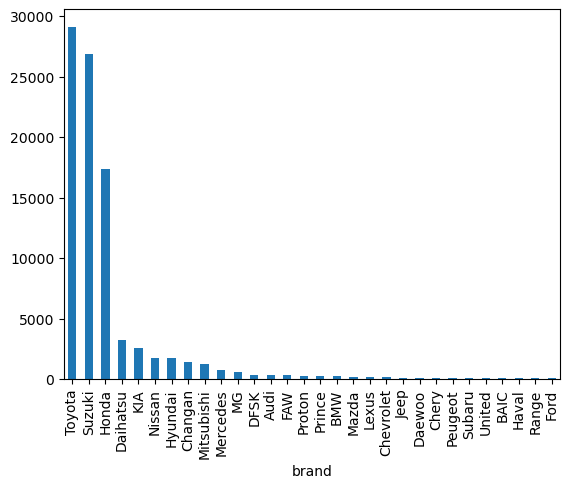

In [23]:
df.brand.value_counts().nlargest(30).plot(kind="bar")

## Dropping brands having less than 1000 listed vehicles


In [24]:
df = df[
    (df["brand"] == "Toyota")
    | (df["brand"] == "Suzuki")
    | (df["brand"] == " Honda")
    | (df["brand"] == "KIA")
    | (df["brand"] == "Daihatsu")
    | (df["brand"] == "Hyundai")
    | (df["brand"] == "Changan")
    | (df["brand"] == "Nissan")
    | (df["brand"] == "Mitsubishi")
]
# df = df[(df['brand'] == 'Toyota') | (df['brand'] == 'Suzuki') | (df['brand'] == ' Honda') | (df['brand'] == 'KIA') | (df['brand'] == 'Daihatsu') | (df['brand'] == 'Hyundai') | (df['brand'] == 'Changan') | (df['brand'] == 'Nissan') | (df['brand'] == 'Mitsubishi') | (df['brand'] == 'Mercedes') | (df['brand'] == 'MG') | (df['brand'] == 'DFSK') | (df['brand'] == 'Audi') | (df['brand'] == 'FAW') | (df['brand'] == 'Proton') | (df['brand'] == 'Prince') | (df['brand'] == 'BMW') | (df['brand'] == 'Mazda') ]

In [25]:
df.shape

(67874, 16)

In [26]:
df.variant.nunique()

925

In [27]:
df.head(1)

,title,location,model_year,price,mileage,engine_type,transmission,registered_in,color,assembly,engine_capacity,body_type,ad_last_updated,brand,vehicle,variant
1,Suzuki Mehran VX Euro II 2012,"Eden Gardens, Faisalabad Punjab",2012.0,PKR 7 lacs,"100,000 km",Petrol,Manual,Faisalabad,Grey,Imported Cars,800 cc,Hatchback,2022-10-09,Suzuki,Mehran,VX Euro II


## Unique value in every columns


In [28]:
columns = df.columns
print("No of unique items in each columns")
print("--------------------------------------------------")
for column in columns:
    print("No of unique items in ", column, " = ", df[column].nunique())
print("--------------------------------------------------")

No of unique items in each columns
--------------------------------------------------
No of unique items in  title  =  7150
No of unique items in  location  =  2329
No of unique items in  model_year  =  33
No of unique items in  price  =  1995
No of unique items in  mileage  =  7716
No of unique items in  engine_type  =  3
No of unique items in  transmission  =  2
No of unique items in  registered_in  =  135
No of unique items in  color  =  23
No of unique items in  assembly  =  2
No of unique items in  engine_capacity  =  134
No of unique items in  body_type  =  21
No of unique items in  ad_last_updated  =  66
No of unique items in  brand  =  8
No of unique items in  vehicle  =  243
No of unique items in  variant  =  925
--------------------------------------------------


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67874 entries, 1 to 89955
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            67874 non-null  object        
 1   location         67873 non-null  object        
 2   model_year       65749 non-null  float64       
 3   price            67873 non-null  object        
 4   mileage          67873 non-null  object        
 5   engine_type      67128 non-null  object        
 6   transmission     67873 non-null  object        
 7   registered_in    67873 non-null  object        
 8   color            66428 non-null  object        
 9   assembly         67874 non-null  object        
 10  engine_capacity  67873 non-null  object        
 11  body_type        61135 non-null  object        
 12  ad_last_updated  67873 non-null  datetime64[ns]
 13  brand            67874 non-null  object        
 14  vehicle          67874 non-null  object    

In [30]:
df.drop(["location", "assembly", "body_type"], axis=1, inplace=True)

In [31]:
df.price.value_counts()

price
Call for price     1074
PKR 7.5 lacs        635
PKR 6.5 lacs        632
PKR 22 lacs         605
PKR 21 lacs         589
PKR 8.5 lacs        557
PKR 19.5 lacs       550
PKR 18.5 lacs       548
PKR 22.5 lacs       540
PKR 25 lacs         526
PKR 21.5 lacs       524
PKR 23 lacs         523
PKR 13.5 lacs       510
PKR 20 lacs         507
PKR 12.5 lacs       500
PKR 18 lacs         497
PKR 7 lacs          484
PKR 5.5 lacs        475
PKR 17.5 lacs       473
PKR 35 lacs         471
PKR 14.5 lacs       458
PKR 10.5 lacs       452
PKR 16.5 lacs       452
PKR 15 lacs         450
PKR 20.5 lacs       445
PKR 9.5 lacs        444
PKR 23.5 lacs       436
PKR 26 lacs         435
PKR 19 lacs         433
PKR 11.5 lacs       431
PKR 26.5 lacs       431
PKR 8 lacs          430
PKR 12 lacs         426
PKR 30 lacs         425
PKR 24 lacs         422
PKR 32 lacs         422
PKR 9 lacs          418
PKR 14 lacs         417
PKR 24.5 lacs       415
PKR 13 lacs         411
PKR 15.5 lacs       410
PKR 6 lacs

<Axes: xlabel='price'>

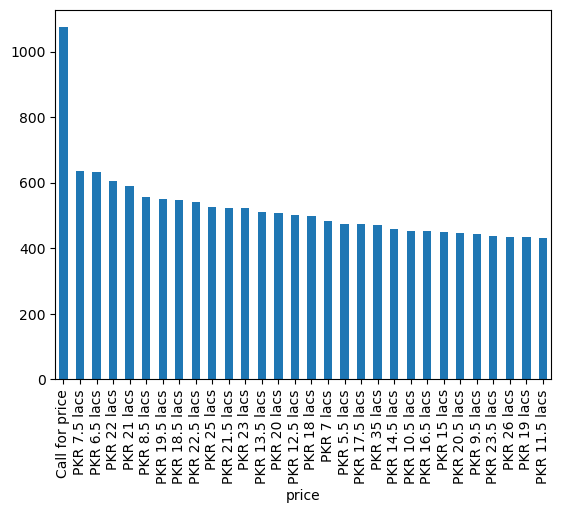

In [32]:
df.price.value_counts().nlargest(30).plot(kind="bar")

## Remove data where price is not provided and correct the format of price and convert it into lacs


In [33]:
df = df[df.price != "Call for price"]

In [34]:
df.head(1)

,title,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,ad_last_updated,brand,vehicle,variant
1,Suzuki Mehran VX Euro II 2012,2012.0,PKR 7 lacs,"100,000 km",Petrol,Manual,Faisalabad,Grey,800 cc,2022-10-09,Suzuki,Mehran,VX Euro II


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66800 entries, 1 to 89955
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            66800 non-null  object        
 1   model_year       64676 non-null  float64       
 2   price            66799 non-null  object        
 3   mileage          66799 non-null  object        
 4   engine_type      66054 non-null  object        
 5   transmission     66799 non-null  object        
 6   registered_in    66799 non-null  object        
 7   color            65411 non-null  object        
 8   engine_capacity  66799 non-null  object        
 9   ad_last_updated  66799 non-null  datetime64[ns]
 10  brand            66800 non-null  object        
 11  vehicle          66800 non-null  object        
 12  variant          66800 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(11)
memory usage: 7.1+ MB


In [36]:
df.dropna(inplace=True)

In [37]:
df["crore"] = df.price.apply(
    lambda x: (x.split(" ")[1]) if "crore" in x.split(" ") else 0
)

In [38]:
df.head(1)

,title,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,ad_last_updated,brand,vehicle,variant,crore
1,Suzuki Mehran VX Euro II 2012,2012.0,PKR 7 lacs,"100,000 km",Petrol,Manual,Faisalabad,Grey,800 cc,2022-10-09,Suzuki,Mehran,VX Euro II,0


In [39]:
df.crore = df.crore.astype(float)

In [40]:
df.crore = df.crore * 100

In [41]:
df.price.value_counts()

price
PKR 22 lacs        578
PKR 7.5 lacs       576
PKR 6.5 lacs       571
PKR 21 lacs        571
PKR 19.5 lacs      528
PKR 22.5 lacs      523
PKR 18.5 lacs      523
PKR 8.5 lacs       515
PKR 21.5 lacs      508
PKR 23 lacs        504
PKR 25 lacs        504
PKR 20 lacs        484
PKR 13.5 lacs      484
PKR 12.5 lacs      475
PKR 18 lacs        475
PKR 17.5 lacs      450
PKR 35 lacs        450
PKR 14.5 lacs      437
PKR 15 lacs        432
PKR 20.5 lacs      431
PKR 10.5 lacs      427
PKR 26 lacs        426
PKR 16.5 lacs      425
PKR 26.5 lacs      424
PKR 23.5 lacs      423
PKR 19 lacs        423
PKR 7 lacs         421
PKR 30 lacs        413
PKR 32 lacs        412
PKR 24 lacs        407
PKR 11.5 lacs      406
PKR 9.5 lacs       405
PKR 12 lacs        404
PKR 24.5 lacs      404
PKR 25.5 lacs      398
PKR 5.5 lacs       398
PKR 13 lacs        391
PKR 14 lacs        390
PKR 15.5 lacs      390
PKR 8 lacs         386
PKR 9 lacs         385
PKR 17 lacs        376
PKR 28.5 lacs      370
PKR 1

In [42]:
df.price = df.price.apply(lambda x: (x.split(" ")[1] if "lacs" in x.split(" ") else 0))

In [43]:
df.price.value_counts()

price
0        2108
22        578
7.5       576
6.5       571
21        571
19.5      528
18.5      523
22.5      523
8.5       515
21.5      508
23        504
25        504
20        484
13.5      484
18        475
12.5      475
35        450
17.5      450
14.5      437
15        432
20.5      431
10.5      427
26        426
16.5      425
26.5      424
23.5      423
19        423
7         421
30        413
32        412
24        407
11.5      406
9.5       405
24.5      404
12        404
25.5      398
5.5       398
13        391
14        390
15.5      390
8         386
9         385
17        376
28.5      370
11        369
6         361
28        360
27        355
29        342
33        339
16        336
31        326
27.5      324
36        318
40        309
10        307
29.5      306
32.5      304
38        300
34        279
36.5      264
37        264
31.5      264
34.5      251
45        245
33.5      235
42        229
35.5      228
30.5      219
4.5       211
6.8       210


In [44]:
df.price = df.price.astype(float)

In [45]:
df.price = df.price + df.crore

In [46]:
df.price.value_counts()

price
22.00      578
7.50       576
6.50       571
21.00      571
19.50      528
22.50      523
18.50      523
8.50       515
21.50      508
23.00      504
25.00      504
20.00      484
13.50      484
12.50      475
18.00      475
17.50      450
35.00      450
14.50      437
15.00      432
20.50      431
10.50      427
26.00      426
16.50      425
26.50      424
23.50      423
19.00      423
7.00       421
30.00      413
32.00      412
24.00      407
11.50      406
9.50       405
12.00      404
24.50      404
25.50      398
5.50       398
13.00      391
14.00      390
15.50      390
8.00       386
9.00       385
17.00      376
28.50      370
11.00      369
6.00       361
28.00      360
27.00      355
29.00      342
33.00      339
16.00      336
31.00      326
27.50      324
36.00      318
40.00      309
10.00      307
29.50      306
32.50      304
38.00      300
34.00      279
31.50      264
36.50      264
37.00      264
34.50      251
45.00      245
33.50      235
42.00      229
35.5

In [47]:
df.head(1)

,title,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,ad_last_updated,brand,vehicle,variant,crore
1,Suzuki Mehran VX Euro II 2012,2012.0,7.0,"100,000 km",Petrol,Manual,Faisalabad,Grey,800 cc,2022-10-09,Suzuki,Mehran,VX Euro II,0.0


In [48]:
df.drop("crore", axis=1, inplace=True)

In [49]:
df.head(1)

,title,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,ad_last_updated,brand,vehicle,variant
1,Suzuki Mehran VX Euro II 2012,2012.0,7.0,"100,000 km",Petrol,Manual,Faisalabad,Grey,800 cc,2022-10-09,Suzuki,Mehran,VX Euro II


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62770 entries, 1 to 89955
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            62770 non-null  object        
 1   model_year       62770 non-null  float64       
 2   price            62770 non-null  float64       
 3   mileage          62770 non-null  object        
 4   engine_type      62770 non-null  object        
 5   transmission     62770 non-null  object        
 6   registered_in    62770 non-null  object        
 7   color            62770 non-null  object        
 8   engine_capacity  62770 non-null  object        
 9   ad_last_updated  62770 non-null  datetime64[ns]
 10  brand            62770 non-null  object        
 11  vehicle          62770 non-null  object        
 12  variant          62770 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 6.7+ MB


In [51]:
df.model_year = df.model_year.astype(int)

In [52]:
df.mileage = df.mileage.apply(lambda x: (x.split(" ")[0]))

In [53]:
df.mileage = df.mileage.apply(lambda x: (x.replace(",", "")))

In [54]:
df.head(1)

,title,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,ad_last_updated,brand,vehicle,variant
1,Suzuki Mehran VX Euro II 2012,2012,7.0,100000,Petrol,Manual,Faisalabad,Grey,800 cc,2022-10-09,Suzuki,Mehran,VX Euro II


In [55]:
df.drop("title", axis=1, inplace=True)

In [56]:
columns = df.columns
print("No of unique items in each columns")
print("--------------------------------------------------")
for column in columns:
    print("No of unique items in ", column, " = ", df[column].nunique())
print("--------------------------------------------------")

No of unique items in each columns
--------------------------------------------------
No of unique items in  model_year  =  33
No of unique items in  price  =  1951
No of unique items in  mileage  =  7165
No of unique items in  engine_type  =  3
No of unique items in  transmission  =  2
No of unique items in  registered_in  =  126
No of unique items in  color  =  23
No of unique items in  engine_capacity  =  118
No of unique items in  ad_last_updated  =  63
No of unique items in  brand  =  8
No of unique items in  vehicle  =  233
No of unique items in  variant  =  893
--------------------------------------------------


In [57]:
df.engine_capacity = df.engine_capacity.apply(lambda x: (x.split(" ")[0]))

In [58]:
df.head(1)

,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,ad_last_updated,brand,vehicle,variant
1,2012,7.0,100000,Petrol,Manual,Faisalabad,Grey,800,2022-10-09,Suzuki,Mehran,VX Euro II


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62770 entries, 1 to 89955
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   model_year       62770 non-null  int32         
 1   price            62770 non-null  float64       
 2   mileage          62770 non-null  object        
 3   engine_type      62770 non-null  object        
 4   transmission     62770 non-null  object        
 5   registered_in    62770 non-null  object        
 6   color            62770 non-null  object        
 7   engine_capacity  62770 non-null  object        
 8   ad_last_updated  62770 non-null  datetime64[ns]
 9   brand            62770 non-null  object        
 10  vehicle          62770 non-null  object        
 11  variant          62770 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(9)
memory usage: 6.0+ MB


In [60]:
df.engine_capacity = df.engine_capacity.astype(int)

In [61]:
df.transmission.value_counts()

transmission
Manual       32840
Automatic    29930
Name: count, dtype: int64

<Axes: xlabel='transmission'>

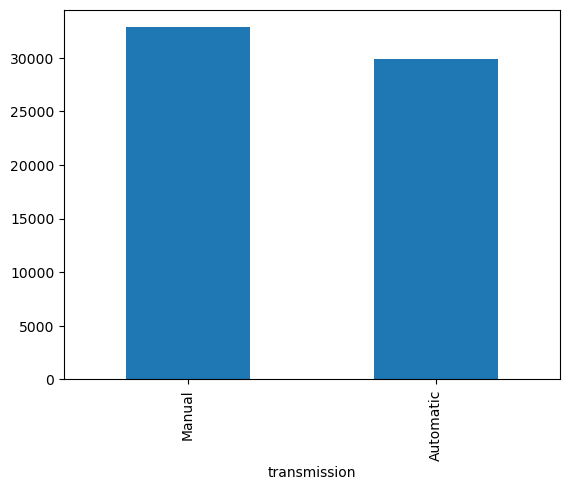

In [62]:
df.transmission.value_counts().plot(kind="bar")

In [63]:
df.engine_type.value_counts()

engine_type
Petrol    57596
Diesel     3212
Hybrid     1962
Name: count, dtype: int64

<Axes: xlabel='engine_type'>

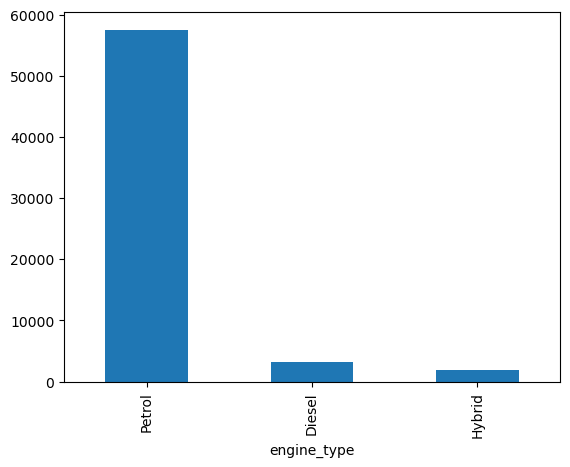

In [64]:
df.engine_type.value_counts().plot(kind="bar")

In [65]:
df.sample(5)

,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,ad_last_updated,brand,vehicle,variant
45588,2022,39.00,9,Petrol,Automatic,Un-Registered,White,1200,2022-09-23,Suzuki,Swift,XG 1.2
86147,1998,3.25,324160,Petrol,Manual,Punjab,White,800,2022-08-29,Suzuki,Mehran,VXR
29849,2013,245.00,103000,Petrol,Automatic,Karachi,Grey,6200,2022-09-21,Nissan,Patrol,4.8L
50229,2019,22.35,65000,Petrol,Automatic,Lahore,Black,660,2022-09-20,Nissan,Dayz,Highway Star
2094,2006,13.95,120000,Petrol,Automatic,Punjab,White,660,2022-10-09,Daihatsu,Move,


In [66]:
df.drop("ad_last_updated", axis=1, inplace=True)

In [67]:
group = df.groupby("vehicle")
df1 = group.apply(lambda x: x["variant"].unique())

In [68]:
z = df["vehicle"].value_counts()

In [69]:
y = z[z < 30]

In [70]:
a = y.index

In [71]:
a = list(a)

# ------------------------------------------------------------------------------------------------------------


In [72]:
df.head(2)

,model_year,price,mileage,engine_type,transmission,registered_in,color,engine_capacity,brand,vehicle,variant
1,2012,7.0,100000,Petrol,Manual,Faisalabad,Grey,800,Suzuki,Mehran,VX Euro II
3,2013,70.0,94000,Petrol,Automatic,Lahore,Black,2700,Toyota,Fortuner,2.7 VVTi


In [73]:
column_order = [
    "model_year",
    "mileage",
    "registered_in",
    "color",
    "engine_capacity",
    "brand",
    "vehicle",
    "variant",
    "transmission",
    "engine_type",
    "price",
]
df = df[column_order]

In [74]:
df.head(2)

,model_year,mileage,registered_in,color,engine_capacity,brand,vehicle,variant,transmission,engine_type,price
1,2012,100000,Faisalabad,Grey,800,Suzuki,Mehran,VX Euro II,Manual,Petrol,7.0
3,2013,94000,Lahore,Black,2700,Toyota,Fortuner,2.7 VVTi,Automatic,Petrol,70.0


## Convert all data to lowercase


In [75]:
# lowercase_if_string = lambda x: x.lower() if isinstance(x, str) else x
# df = df.applymap(lowercase_if_string)

In [76]:
df.head(10)

,model_year,mileage,registered_in,color,engine_capacity,brand,vehicle,variant,transmission,engine_type,price
1,2012,100000,Faisalabad,Grey,800,Suzuki,Mehran,VX Euro II,Manual,Petrol,7.00
3,2013,94000,Lahore,Black,2700,Toyota,Fortuner,2.7 VVTi,Automatic,Petrol,70.00
4,2015,86000,Multan,Grey,796,Suzuki,Mehran,VX Euro II,Manual,Petrol,8.00
5,2012,85000,Lahore,Silver,1600,Toyota,Corolla,Altis SR Cruisetronic 1.6,Automatic,Petrol,25.50
6,2011,97000,Lahore,Silver,660,Suzuki,MR,Wagon WIT LIMITED,Automatic,Petrol,13.00
8,2018,28000,Karachi,Black,1600,Toyota,Corolla,Altis X Automatic 1.6 Special Edition,Automatic,Petrol,36.60
9,2020,14500,Un-Registered,White,1000,Toyota,Raize,,Automatic,Petrol,51.75
10,2006,125000,Faisalabad,White,1000,Toyota,Vitz,B 1.0,Automatic,Petrol,15.75
12,2016,96000,Islamabad,White,1800,Toyota,Corolla,Altis Grande CVT-i 1.8,Automatic,Petrol,36.20
14,2022,50,Lahore,White,2800,Toyota,Hilux,Revo V Automatic 2.8,Automatic,Diesel,115.00


In [77]:
print("We have data of", df.shape[0], "vehicles")

We have data of 62770 vehicles


In [78]:
# reset index and save data
df.reset_index(drop=True, inplace=True)
df.to_csv("cleaned_data.csv", index=True)

<Axes: xlabel='color'>

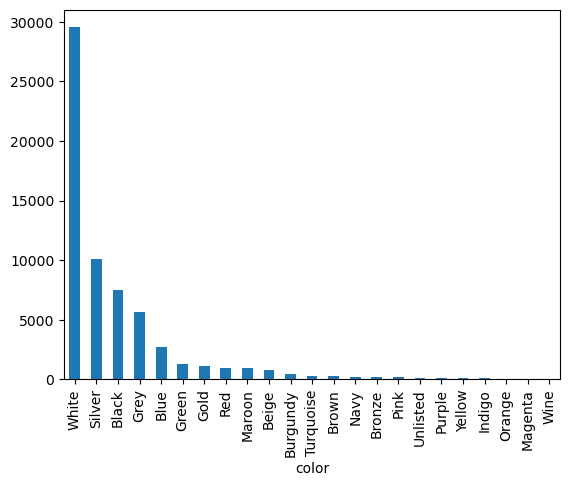

In [79]:
df.color.value_counts().nlargest(30).plot(kind="bar")

In [80]:
df = df[
    (df["color"] == "Grey")
    | (df["color"] == "Black")
    | (df["color"] == "Silver")
    | (df["color"] == "White")
    | (df["color"] == "Blue")
    | (df["color"] == "Green")
    | (df["color"] == "Maroon")
    | (df["color"] == "Red")
    | (df["color"] == "Burgundy")
    | (df["color"] == "Turquoise")
    | (df["color"] == "Gold")
    | (df["color"] == "Beige")
    | (df["color"] == "Brown")
    | (df["color"] == "Navy")
    | (df["color"] == "Yellow")
]

In [81]:
df.shape

(62004, 11)

In [82]:
df.drop(['variant', 'engine_capacity'], axis=1, inplace=True)

In [83]:
df.shape

(62004, 9)

In [84]:
df.reset_index(drop=True, inplace=True)
df.to_csv("New_cleaned_data.csv", index=True)

# ---------------------------------------------------------------------------------------------------------------


# -------------------------Try different model to select one of them----------------------------


# Train Test Split


In [85]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns=["price"], axis=1), df["price"], test_size=0.3, random_state=12
)

In [86]:
x_train.head(2)

,model_year,mileage,registered_in,color,brand,vehicle,transmission,engine_type
41525,2019,31000,Karachi,White,Toyota,Corolla,Automatic,Petrol
53018,2015,90469,Karachi,Gold,Suzuki,Mehran,Manual,Petrol


# Lets try Random Forest Regressor


In [87]:
tf1_rfr = ColumnTransformer(
    [("OHE", OneHotEncoder(sparse=False, drop="first"), [6, 7])],
    remainder="passthrough",
)
tf2_rfr = ColumnTransformer(
    [
        (
            "Ordinal Encoding",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
            [4, 5, 6, 7, 8],
        )
    ],
    remainder="passthrough",
)
tf3_rfr = ColumnTransformer(
    [
        (
            "Nan Imputer",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
            slice(0, 9),
        )
    ]
)
tf4_rfr = ColumnTransformer([("Standard Scaler", StandardScaler(), slice(0, 9))])
m_rfr = RandomForestRegressor()

pipe_rfr = Pipeline(
    [
        ("One Hot Encoder", tf1_rfr),
        ("Ordinal Encoding", tf2_rfr),
        ("Nan Imputer", tf3_rfr),
        ("StandardScaler", tf4_rfr),
        ("Random Forest Regressor", m_rfr),
    ]
)

pipe_rfr.fit(x_train, y_train)


y_predict_rfr = pipe_rfr.predict(x_test)


print("MAE = ", mean_absolute_error(y_test, y_predict_rfr))
print("MSE = ", mean_squared_error(y_test, y_predict_rfr))
print("RMSE = ", np.sqrt(mean_squared_error(y_test, y_predict_rfr)))
print("r2 Score = ", r2_score(y_test, y_predict_rfr))


set_config(display="diagram")
pipe_rfr

c:\Users\chmub\miniconda3\envs\cars_price\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MAE =  2.8744607933283373
MSE =  77.88049045893563
RMSE =  8.824992377273514
r2 Score =  0.9431879539592757


Pipeline(steps=[('One Hot Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  [6, 7])])),
                ('Ordinal Encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Ordinal Encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  [4, 5, 6, 7, 8])])),
                ('Nan Imputer',
                 ColumnTransformer(transformers=[('Nan Imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  slice(0, 9, None))])),
                ('StandardScaler',
                 ColumnTransformer(transformers=[('Standard Scaler',
                                                  StandardScaler(),
                                                  slice(0, 9, None))])),
                ('Random Forest Regressor', RandomForestRegressor())])

In [88]:
import pickle

# Save the trained pipeline to a file
model_filename = "RandomForestRegressorModel.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(pipe_rfr, model_file)

print(f"Random Forest Regressor Model saved as {model_filename}")

Random Forest Regressor Model saved as RandomForestRegressorModel.pkl


# Lets try Ensemble learning with 2 Random Forest Regressor


In [ ]:
# tf1 = ColumnTransformer(
#     [("OHE", OneHotEncoder(sparse=False, drop="first"), [6, 7])],
#     remainder="passthrough",
# )
# tf2 = ColumnTransformer(
#     [
#         (
#             "Ordinal Encoding",
#             OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
#             [4, 5, 6, 7, 8],
#         )
#     ],
#     remainder="passthrough",
# )
# tf3 = ColumnTransformer(
#     [
#         (
#             "Nan Imputer",
#             SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
#             slice(0, 9),
#         )
#     ]
# )
# tf4 = ColumnTransformer([("Standard Scaler", StandardScaler(), slice(0, 9))])
# m1 = RandomForestRegressor()
# m2 = RandomForestRegressor()
# ensemble_model = VotingRegressor(estimators=[("model1", m1), ("model2", m2)])


# pipe_2rfr = Pipeline(
#     [
#         ("One Hot Encoder", tf1),
#         ("Ordinal Encoding", tf2),
#         ("Nan Imputer", tf3),
#         ("StandardScaler", tf4),
#         ("EnsembleModel", ensemble_model),
#     ]
# )


# pipe_2rfr.fit(x_train, y_train)


# y_predict = pipe_2rfr.predict(x_test)


# print("MAE = ", mean_absolute_error(y_test, y_predict))
# print("MSE = ", mean_squared_error(y_test, y_predict))
# print("RMSE = ", np.sqrt(mean_squared_error(y_test, y_predict)))
# print("r2 Score = ", r2_score(y_test, y_predict))


# set_config(display="diagram")
# pipe_2rfr

# Lets try Ensemble learning with 3 Random Forest Regressor


In [ ]:
# tf1 = ColumnTransformer(
#     [("OHE", OneHotEncoder(sparse=False, drop="first"), [6, 7])],
#     remainder="passthrough",
# )
# tf2 = ColumnTransformer(
#     [
#         (
#             "Ordinal Encoding",
#             OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
#             [4, 5, 6, 7, 8],
#         )
#     ],
#     remainder="passthrough",
# )
# tf3 = ColumnTransformer(
#     [
#         (
#             "Nan Imputer",
#             SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
#             slice(0, 9),
#         )
#     ]
# )
# tf4 = ColumnTransformer([("Standard Scaler", StandardScaler(), slice(0, 9))])
# m1 = RandomForestRegressor()
# m2 = RandomForestRegressor()
# m3 = RandomForestRegressor()
# ensemble_model = VotingRegressor(
#     estimators=[("model1", m1), ("model2", m2), ("model3", m3)]
# )


# pipe_3rfr = Pipeline(
#     [
#         ("One Hot Encoder", tf1),
#         ("Ordinal Encoding", tf2),
#         ("Nan Imputer", tf3),
#         ("StandardScaler", tf4),
#         ("EnsembleModel", ensemble_model),
#     ]
# )


# pipe_3rfr.fit(x_train, y_train)


# y_predict = pipe_3rfr.predict(x_test)


# print("MAE = ", mean_absolute_error(y_test, y_predict))
# print("MSE = ", mean_squared_error(y_test, y_predict))
# print("RMSE = ", np.sqrt(mean_squared_error(y_test, y_predict)))
# print("r2 Score = ", r2_score(y_test, y_predict))


# set_config(display="diagram")
# pipe_3rfr

In [ ]:
# import pickle

# # Save the trained pipeline to a file
# model_filename = "RandomForestRegressorModel.pkl"
# with open(model_filename, "wb") as model_file:
#     pickle.dump(pipe_3rfr, model_file, protocol=pickle.HIGHEST_PROTOCOL)

# print(f"Random Forest Regressor Model saved as {model_filename}")